In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp

from copy import copy
from unidecode import unidecode
from functools import reduce
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from bias_correction import BiasCorrection, XBiasCorrection

relevant_municipalities = ["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]
month_name_to_number = {
    "JAN":1, "FEB":2, "MAR":3, "APR":4, "MAY":5, "JUN":6, "JUL":7, "AUG":8, "SEP":9, "OCT":10, "NOV":11, "DEC":12
    }

%load_ext autoreload
%autoreload 2

### 1. Read data

**Polygon shapes**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. In this notebook we read hindcasts from the APCC CLIK that is provided in 2.5° x 2.5° grid cells. For each location, we need to find the grid cells that are closest. 

In [2]:
# polygon shapes of the two municipalities that are relevant for the forecast model
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# filter the two relevant names
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]), ["name", "geometry"]].reset_index(drop=True)
# convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# preview
name_to_shape

{'buenos aires coronel dorrego': <POLYGON Z ((-61.175 -38.293 0, -61.174 -38.293 0, -61.173 -38.293 0, -61.17...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**ERA data**

The ERA5-Land-Reanalysis [Dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=form) is needed to bias-adjustment.

In [68]:
era = pd.read_csv("data/era_filtered_locations.csv").assign(model="ERA", init_month=12)
# the redundant part of the location "Buenoas Aires" can be removed
era["name"] = era["name"].apply(lambda x: x.replace("buenos aires ", ""))
era = era[["model", "year", "init_month", "month", "rain", "tmean", "name"]]
era.columns = ["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]
# preview
era.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,ERA,1993,12,8,0.000204,10.112333,coronel dorrego
1,ERA,1994,12,8,0.001294,9.102000,coronel dorrego


### APCC CLIK

The [Climate Information Toolkit (CLIK) from the APEC Climate Center (APCC)](https://cliks.apcc21.org/)(CLIK) consists of fifteen Seasonal climate models whose hindcasts are available to download [here](https://cliks.apcc21.org/dataset/model). Alternatively, CLIK has an API that we used in our research. More information is available [here](https://cliks.apcc21.org/contents/openapi). Out of the fifteen models that are part of the APCC MME, we collected data from five. Partly because some data was not consistently available for all years and months of initialization, and partly because the data was already collected from the NMME or the Copernicus Climate Data Store (more in *../c3s/* or *../nmme/*)

- BoM ACCESS-S2 from Australia - **BOM**
- PNU-RDA CGCMv2.0 from Korea - **PNU**
- CWB TCWB1Tv1.1 from Chinese Taipei - **CWB**
- HMC SL-AV from Russia - **HMC**
- KMA GloSea6GC3.2 from Korea - **KMA**
- NCEP CFSv2 from the USA - **collected from NMME**
- METFR SYS8 from France - **collected from C3S**
- CMCC SOS3.5 from Italy - **collected from C3S**
- UKMO GloSea6 from the UK - **collected from C3s**
- ECCC CANSIPSv2.1 from Canada - **collected from C3S**
- APCC SCoPS from Korea - **not considered, because of missing data**
- BCC CSM1.1m from China - **not considered, because of missing data**
- MGO MGOAM-2 grom Russia - **not considered, because of missing data**


In [4]:
def read_data(model_name_as_string):
    """Read netcdf4 data files and concatenates them to one dataframe.
    Params:
     - model_name_as_string: string, the name of the model
     Returns:
      - hindcasts: dataframe
    """
    list_temp = []
    list_prec = []
    climate_vars = ["prec", "t2m"]
    directory_as_str = "data/" + model_name_as_string + "/"
    directory = os.fsencode(directory_as_str)
    # to print progress of reading files
    total_number_of_files = len([entry for entry in os.listdir(directory_as_str) if os.path.isfile(os.path.join(directory_as_str, entry))])
    print("job started, there are {} files to iterate".format(total_number_of_files))  
    counter = 0
    for file in os.listdir(directory):
        
        counter += 1
        filename = os.fsdecode(file)
        if filename.endswith("nc"):
            # info about hindcasts are part of the filename
            splitted_filename = filename.split("_") 
            init_month = splitted_filename[-3]
            year = int(splitted_filename[-2])
            model_year = splitted_filename[0][-4:]
            df = (xr
                  .open_dataset(directory_as_str + filename, engine="netcdf4")
                  .to_dataframe()
                  .reset_index()
                  .assign(model=model_name_as_string, model_year=model_year, init_year=year, 
                          init_month=init_month, forecasted_year=lambda x: pd.to_datetime(x["time"]).dt.year, forecasted_month=lambda x: pd.to_datetime(x["time"]).dt.month)
                  .groupby(["model", "model_year", "init_year", "init_month", "forecasted_year", "forecasted_month", "time", "lat", "lon"])
                  .mean())
            df = df.loc[:, [c for c in df.columns if c in climate_vars]]
            if filename.endswith("prec.nc"): list_prec.append(df)
            if filename.endswith("t2m.nc"): list_temp.append(df)
        if counter % 30 == 0:
            print(str(counter) + "/" + str(total_number_of_files))
    
    print("concatenating temp and rain..")        
    hindcasts_prec = pd.concat(list_prec, axis=0, ignore_index=False)
    hindcasts_temp = pd.concat(list_temp, axis=0, ignore_index=False)
    hindcasts = hindcasts_prec.combine_first(hindcasts_temp).reset_index()
    print("job finished")
    return hindcasts
    

In [8]:
pnu = read_data("PNU")

job started, there are 576 files to iterate
30/576
60/576
90/576
120/576
150/576
180/576
210/576
240/576
270/576
300/576
330/576
360/576
390/576
420/576
450/576
480/576
510/576
540/576
570/576
concatenating temp and rain..
job finished


In [9]:
kma = read_data("KMA")

job started, there are 576 files to iterate
30/576
60/576
90/576
120/576
150/576
180/576
210/576
240/576
270/576
300/576
330/576
360/576
390/576
420/576
450/576
480/576
510/576
540/576
570/576
concatenating temp and rain..
job finished


In [7]:
cwb = read_data("CWB")

job started, there are 576 files to iterate
30/576
60/576
90/576
120/576
150/576
180/576
210/576
240/576
270/576
300/576
330/576
360/576
390/576
420/576
450/576
480/576
510/576
540/576
570/576
concatenating temp and rain..
job finished


In [6]:
hmc = read_data("HMC")

job started, there are 566 files to iterate
30/566
60/566
90/566
120/566
150/566
180/566
210/566
240/566
270/566
300/566
330/566
360/566
390/566
420/566
450/566
480/566
510/566
540/566
concatenating temp and rain..
job finished


In [5]:
bom = read_data("BOM")

job started, there are 576 files to iterate
30/576
60/576
90/576
120/576
150/576
180/576
210/576
240/576
270/576
300/576
330/576
360/576
390/576
420/576
450/576
480/576
510/576
540/576
570/576
concatenating temp and rain..
job finished


In [54]:
hindcasts = pd.concat([bom, pnu, cwb, hmc, kma], ignore_index=True)

### 2. Preprocessing

In [55]:
# change coordinate reference units
hindcasts["lon"] = hindcasts["lon"].apply(lambda x: x - 360 if x > 180 else x)
# filter roughly by relevant area of Argentina
hindcasts = hindcasts.loc[(hindcasts["lat"] <= -28) & (hindcasts["lat"] >= -45) & (hindcasts["lon"] >= -68) & (hindcasts["lon"] <= -55)].reset_index(drop=True)
# replace month names to integer
hindcasts["init_month"] = hindcasts["init_month"].replace(month_name_to_number)
# convert tempearture from Kelvin to degree celsius
hindcasts["t2m"] = hindcasts["t2m"].apply(lambda x: x - 273.15)
# convert rain to mm to match with ERA-reanalysis
hindcasts["prec"] = hindcasts["prec"].apply(lambda x: x / 1000)
# filter by init month and forecasted month; HMC is not available for init_month < 9, but we need 8 as feature, will be supplemented with ERA and filtered later
hindcasts = (hindcasts
             .loc[(hindcasts["init_month"].between(8, 11)) & (hindcasts["forecasted_month"].between(8, 11)) & (hindcasts["forecasted_year"] == hindcasts["init_year"]),
                  ["model", "init_year", "init_month", "forecasted_month", "prec", "t2m", "lat", "lon"]]
                .rename(columns={"init_year":"year", "prec":"rain", "t2m":"tmean"})
                .reset_index(drop=True))

# convert to geodataframe to facilitate spatial filtering in the next section
hindcasts = gp.GeoDataFrame(hindcasts, geometry=gp.points_from_xy(hindcasts["lon"], hindcasts["lat"]), crs="EPSG:4326")

In [56]:
hindcasts.head(2)

,model,year,init_month,forecasted_month,rain,tmean,lat,lon,geometry
0,BOM,1993,8,8,0.000858,4.104913,-45.0,-67.5,POINT (-67.50000 -45.00000)
1,BOM,1993,8,8,0.000947,6.767725,-45.0,-65.0,POINT (-65.00000 -45.00000)


### 3. Find closest location to municipalities

In [57]:
modelling_groups = hindcasts["model"].unique()
li = []
for model in modelling_groups:
    # get current model and the lat-lon coordinates of its forecasts
    current_model = hindcasts.loc[hindcasts["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    # get the nearest lat-lon pair to both locations (municipalities)
    location_1 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[0]])[1][0]]).transpose().assign(location="coronel dorrego").reset_index(drop=True)
    location_2 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[1]])[1][0]]).transpose().assign(location="hipolito yrigoyen").reset_index(drop=True)
    # save in dataframe
    locations = pd.concat([location_1, location_2], ignore_index=True)
    # the lat-lon pairs that are selected are merged with the name of their location; all other lat-lon pairs are dropped
    current_model = current_model.merge(locations, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    # append the locations for this model
    li.append(current_model)
    
model_locations = pd.concat(li, ignore_index=True, axis=0)
# dataframe is now called CLIK 
clik = hindcasts.merge(model_locations, on=["model", "lat", "lon", "geometry"]).dropna()

<Axes: >

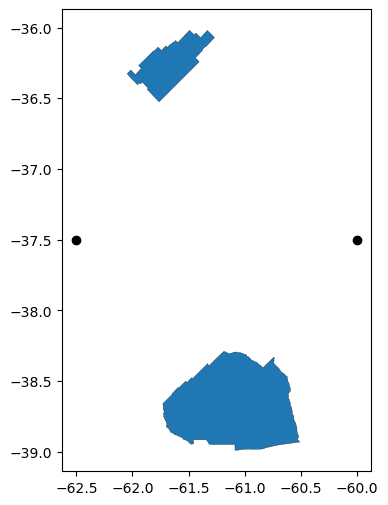

In [58]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(clik[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

In [74]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to daily temperature values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["location", "year", "forecasted_month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "location", "year", "forecasted_month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content["model"].unique()[0]
        current_init_month = group_content["init_month"].unique()[0]
        current_zone = group_content["location"].unique()[0]
        current_season = group_content["year"].unique()[0]
        current_month = group_content["forecasted_month"].unique()[0]
        
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in list(range(1993,2017)): 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
            hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
            hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_rain = BiasCorrection(observations_used_as_reference["rain"], hindcasts_used_as_reference["rain"], group_content["rain"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["rain"] = bc_rain.correct(method=correction_method)
        
        li.append(group_content)
    result = pd.concat(li, axis=0, ignore_index=True)       
    
    return result

In [70]:
adjusted_hindcasts = adjust_bias(era, clik)

### 5. Features structure 

In [76]:
# Bring NMME hindcasts into right structure where features are columns and rows are model-year-init_month
hindcasts_pivot = adjusted_hindcasts.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
hindcasts_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in hindcasts_pivot.columns]
hindcasts_pivot.columns = [c.strip("_") for c in hindcasts_pivot.columns]

# Bring ERA into right structure where features are columns and rows are model-year
era_pivot = era.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
era_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in era_pivot.columns]
era_pivot.columns = [c.strip("_") for c in era_pivot.columns]
era_pivot = era_pivot.sort_values(by=["model", "year", "init_month"])

# features for month < init_months are NaNs and will be replaced with era-reanalysis data
all_models = hindcasts_pivot.set_index("year").combine_first(era_pivot.set_index("year")).reset_index()
# concat ERA with init_month = 12  
all_models = pd.concat([all_models, era_pivot], ignore_index=True)
all_models = all_models.drop_duplicates().reset_index(drop=True)
all_models = all_models.loc[all_models["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)

# bring columns into right order
all_models = all_models[
    ['model', 'year', 'init_month', 'rain_coronel dorrego_10', 'rain_coronel dorrego_11', 'rain_coronel dorrego_8', 'rain_coronel dorrego_9', 'rain_hipolito yrigoyen_10', 
     'rain_hipolito yrigoyen_11', 'rain_hipolito yrigoyen_8', 'rain_hipolito yrigoyen_9', 'tmean_coronel dorrego_10', 'tmean_coronel dorrego_11', 'tmean_coronel dorrego_8', 
     'tmean_coronel dorrego_9', 'tmean_hipolito yrigoyen_10', 'tmean_hipolito yrigoyen_11', 'tmean_hipolito yrigoyen_8', 'tmean_hipolito yrigoyen_9']
    ]

all_models.head()

,model,year,init_month,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel dorrego_8,rain_coronel dorrego_9,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11,rain_hipolito yrigoyen_8,rain_hipolito yrigoyen_9,tmean_coronel dorrego_10,tmean_coronel dorrego_11,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,tmean_hipolito yrigoyen_8,tmean_hipolito yrigoyen_9
0,BOM,1993,9,0.003156,0.003315,0.000204,0.003024,0.003897,0.003932,0.000622,0.004287,13.417123,16.459535,10.112333,10.012685,14.735237,17.580730,10.272308,10.916235
1,BOM,1993,10,0.002996,0.002440,0.000204,0.000629,0.002625,0.003344,0.000622,0.002687,13.153378,17.334211,10.112333,11.635667,14.692238,18.756839,10.272308,11.610769
2,BOM,1993,11,0.001886,0.003443,0.000204,0.000629,0.002157,0.003908,0.000622,0.002687,14.787833,16.579685,10.112333,11.635667,16.042308,17.314909,10.272308,11.610769
3,BOM,1994,9,0.004603,0.003936,0.001294,0.004090,0.006222,0.003933,0.002331,0.003535,13.064657,16.587822,9.102000,10.464281,14.801586,17.650340,9.853077,11.743266
4,BOM,1994,10,0.004597,0.006267,0.001294,0.000819,0.005173,0.007149,0.002331,0.001586,14.079286,17.291641,9.102000,11.997500,15.322899,18.713781,9.853077,12.882308


In [77]:
all_models.groupby("model").size()

model
BOM    72
CWB    72
ERA    30
HMC    72
KMA    72
PNU    72
dtype: int64

### EXPORT

In [81]:
all_models.to_csv("data/features/bias_adjusted_clik_features.csv", index=False)